In [1]:
import glob
from os import makedirs
import os 
import scipy
import imageio
import random
import matplotlib.pyplot as plt
import numpy as np
import cv2
from config import config
import pickle
import sklearn
import dataset
import ops
import model
import tensorflow as tf
import keras.backend as K

Using TensorFlow backend.


In [2]:
config['batch_size'] = 1

In [3]:
config_pro = tf.ConfigProto()
config_pro.gpu_options.allow_growth = False
config_pro.gpu_options.per_process_gpu_memory_fraction = 0.9
sess = tf.Session(config=config_pro)
K.set_session(sess)

In [4]:
data = dataset.DLoader(config, augment=True)
test_data = dataset.DLoader(config, augment=False)

Batch size: 1, Thread num: 10
in shape: [None, None, 1] label shape: [None, None, 1]
load dataset done
data size: 700
Batch size: 1, Thread num: 10
in shape: [None, None, 1] label shape: [None, None, 1]
load dataset done
data size: 700


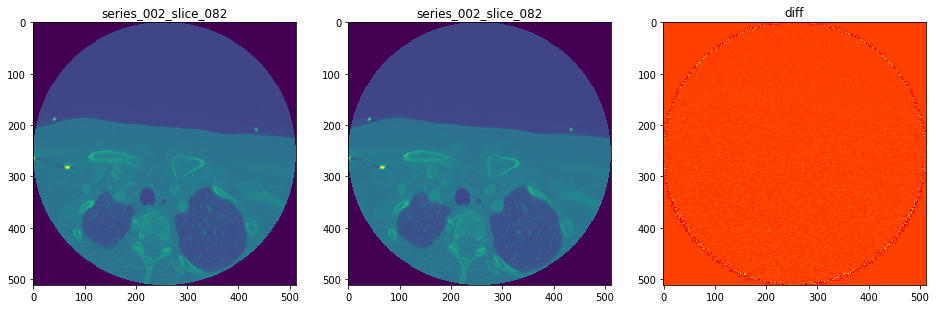

max: 255.0, min: 0.0, mean: 63.382266998291016, std: 39.58882132868084
max: 255, min: 0, mean: 63.308837890625, std: 39.6908488377611
max: 43.0, min: -37.00000000000001, mean: -0.07342910766601739, std: 1.7503787727323872
dif rmse: 74.9851


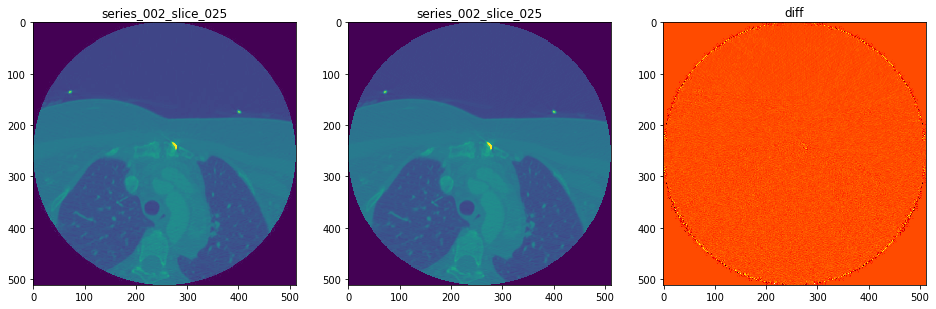

max: 255.0, min: 0.0, mean: 63.38042449951172, std: 39.045398003658974
max: 255, min: 0, mean: 63.31639862060547, std: 39.141032155520634
max: 38.0, min: -35.0, mean: -0.06402587890625133, std: 1.7306708730191886
dif rmse: 74.7065


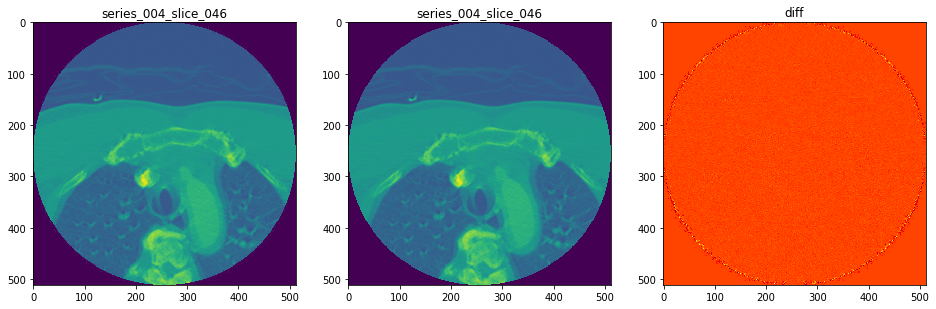

max: 254.0, min: 0.0, mean: 87.67975997924805, std: 55.11348187686973
max: 255, min: 0, mean: 87.62136459350586, std: 55.20353784645363
max: 48.0, min: -42.0, mean: -0.0583953857421875, std: 1.9628061660108649
dif rmse: 103.5966


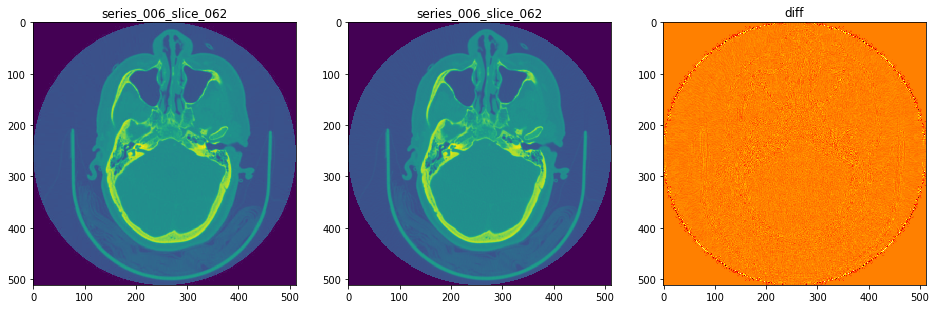

max: 255.0, min: 0.0, mean: 79.53351974487305, std: 54.27594925642912
max: 255, min: 0, mean: 79.48102569580078, std: 54.346563146757056
max: 28.0, min: -35.0, mean: -0.05249404907226573, std: 1.834861542044551
dif rmse: 96.3570


In [5]:
samples = []
samples= [data.train_data[random.randint(0, len(data.train_data)-1)] for x in range(4)]
test_imgs, test_labels, test_names = test_data.get_batch_imgs(samples, ret_names=True)

for i in range(len(test_imgs)):
    jpg_img, bmp_img = ops.plot_one_of_each((test_imgs[i][:,:,0]+1)*127.5, test_labels[i][:,:,0], test_names[i])
    dif = ops.plot_dif((test_imgs[i]+1)*127.5, test_labels[i])
    print('dif rmse: {:.4f}'.format(ops.get_rmse(test_imgs[i][:,:,0], test_labels[i][:,:,0])))

since there is a lot of similarity bw consequitive slices I dont want to train on slice Xi and then test on Xi+1, so to minimize this type of 'over fit' risk - 
1. I would test on patients that were not part of the training/validation
2. I would split train-validation randomly while making sure minimal similarity per patient

In [6]:
# seperate_by_ftype(path)    

In [6]:
import imp
import ops
ops = imp.reload(ops)

In [7]:
[config['batch_size']] + config['img_inp_shape'], [config['batch_size']] + config['out_shape']

([1, None, None, 1], [1, None, None, 1])

In [8]:
(train_x, train_y) = data.get_inputs()
train_x.set_shape([config['batch_size']] + config['img_inp_shape'])
train_y.set_shape([config['batch_size']] + config['out_shape'])
model = model.DfnNet(train_y, train_x, bn_moment=0.69)

In [9]:
bmp_loss2_scalar = tf.summary.scalar('bmp_loss_-2', model.loss_1)
bmp_loss1_scalar = tf.summary.scalar('bmp_loss_-1', model.loss_2)
bmp_loss_scalar = tf.summary.scalar('bmp_loss', model.loss_3)
train_loss_scalar = tf.summary.scalar('train_loss', model.loss)
training_loss_summary = tf.summary.merge(
    [bmp_loss_scalar, bmp_loss1_scalar, bmp_loss2_scalar, train_loss_scalar])

In [10]:
chkp_save_root = config['log_root'] +'/checkpoints'
last_chkp = ''

saver = tf.train.Saver()
if last_chkp == '':
    sess.run(tf.global_variables_initializer())
    last_epoch = 0
    last_eval = 0
    print('initialized new session. chkp #', last_epoch)
else:
    if last_chkp == 'last':
        try:
            last_chkp = tf.train.latest_checkpoint(chkp_save_root)
        except:
            pass
    last_epoch = int(last_chkp.split('-')[-1])
    last_eval = float(os.path.basename(last_chkp).split('.ckpt')[0].split('_')[-1])
    saver.restore(sess, last_chkp)   
    print('loaded session. chkp #', last_epoch, 'last eval:', last_eval)

img_save_root = config['log_root'] +'/output_imgs/'
tb_save_root = config['log_root'] +'/TB/'

for path in [img_save_root, tb_save_root, chkp_save_root]:
    ops.create_dir(path)

train_writer = tf.summary.FileWriter(tb_save_root)

initialized new session. chkp # 0


In [19]:
def save_predict(test_imgs, test_labels, folders, epoch, log_root=config['log_root']):
    scores = []
    predict_out = [model.bmp_predict, model.bmp_m1, model.bmp_m2]
    
    for j in range(len(test_imgs)):
        bmp, bmp_m1, bmp_m2 = sess.run(predict_out, feed_dict={model.x: np.array([test_imgs[j]]),
                                                      model.label: np.array([test_labels[j]]),
                                                      K.learning_phase(): 1})
        name = os.path.basename(folders[j])[1]
        scores.append(ops.get_rmse(bmp[0][:,:,0], test_labels[i][:,:,0]))
        ops.save_image(bmp[0][:,:,0], log_root +'/output_imgs/bmp' , epoch, j, scores[j], name)
        score = ops.get_rmse(bmp_m1[0][:,:,0], test_labels[i][:,:,0])
        ops.save_image(bmp_m1[0][:,:,0], log_root +'/output_imgs/bmp_m1' , epoch, j, score, name)
        score = ops.get_rmse(bmp_m2[0][:,:,0], test_labels[i][:,:,0])
        ops.save_image(bmp_m2[0][:,:,0], log_root +'/output_imgs/bmp_m2' , epoch, j, score, name)
    return scores
        
        
def eval_rmse(val_data, epoch, iou_pbar, batch_size, total_batches, sess, predict_out):
    scores = []
    val_pbar.start()

    for k in range(0, len(val_data)//batch_size, batch_size):
        x = val_data[k:k+batch_size]
        val_imgs, val_labels = [], []

        for l in range(len(x)):
            val_img, val_label = test_data.get_img_label(val_data[k+l])
            val_imgs.append(val_img)
            val_labels.append(val_label)
        bmp_pred = sess.run(predict_out, feed_dict={model.x: val_imgs, K.learning_phase(): 1})

        for l in range(batch_size):
            scores.append(ops.get_rmse(bmp_pred[0][:,:,0], test_labels[i][:,:,0]))

        time.sleep(1e-8)
        val_pbar.update(k)
    avg_rmse = np.mean(scores)
    val_pbar.finish()
    
    print('Epoch:{}, LR:{:.3e}, avg_rmse:{:.5}, for {} val images'.format(
        epoch, run_lr, avg_rmse, len(val_data)))
    return avg_rmse

In [12]:
import threading
import progressbar
import time
from progressbar import Bar, ETA, Percentage, ProgressBar, SimpleProgress

In [20]:
nb_epochs = 200
# SETPS_IN_EPOCH = data.get_size() - 1
SETPS_IN_EPOCH = len(data.val_data)*1
EVAL_STEPS = len(data.val_data)//config['batch_size']
eval_every = 1
save_imgs_to_file = True
batch_size = config['batch_size']
run_lr = 5e-5
decay_lr = 0.0
lr_min = 1e-9
last_eval = 80
# last_epoch = 0
not_improved_count = 0
decay_lr_epochs = 4

data.start_threads(sess)

# Training
train_widgets = ['Train: ', Percentage(), '(', SimpleProgress(), ') ',Bar(marker='#', left='[', right=']'), ' ', ETA()]
val_widgets = ['Evaluate: ', Percentage(), '(', SimpleProgress(), ') ',Bar(marker='*', left='[', right=']'), ' ', ETA()]

train_bar = ProgressBar(widgets=train_widgets, maxval=SETPS_IN_EPOCH)
val_pbar = ProgressBar(widgets=val_widgets, maxval=EVAL_STEPS)

In [21]:
for i in range(last_epoch, last_epoch+nb_epochs):
    avg_loss = []
    print('start training.. LR: {:.3e}'.format(run_lr))
    
    train_bar.start()

    for j in range(SETPS_IN_EPOCH):
        sess.run(model.train_step, feed_dict={K.learning_phase(): 1, model.tf_learning_rate: run_lr})
        loss, train_summary, step = sess.run([model.loss, training_loss_summary, model.tf_global_step],
                                             feed_dict={K.learning_phase(): 1})
        train_writer.add_summary(train_summary, global_step=step)
        avg_loss.append(loss)
        time.sleep(1e-8)
        train_bar.update(j)
    
    train_bar.finish()

    print("Epoch %d/%d - avg_loss: %g" % (i+1, last_epoch+nb_epochs, np.mean(avg_loss)))
    
    if save_imgs_to_file:
        scores = save_predict(test_imgs, test_labels, test_names, i+1)
        print('imgs saved to file. scores:',
              ['{:.4f}'.format(s) for s in scores],
              'avg scores: {:.4f}'.format(np.mean(scores)))
    
    if i%eval_every == 0:
        avg_rmse = eval_rmse(
            data.val_data, i+1, val_pbar, config['batch_size'], EVAL_STEPS, sess, model.bmp_predict)
        
    if avg_rmse < last_eval:
        save_path = chkp_save_root+'/model_{:.4f}_{:.3e}_{:.5f}.ckpt'.format(
            np.mean(avg_loss), run_lr, avg_rmse)
        saver.save(sess, save_path, global_step=i+1)
        last_eval = avg_rmse
        print('saved chkp to path:', save_path)
        not_improved_count = 0
    else:
        if not_improved_count >= decay_lr_epochs:
            run_lr *= (1-decay_lr)
            not_improved_count = 0
        else:
            not_improved_count += 1
    run_lr = max(lr_min, run_lr)
    print('LR: {:.4e}'.format(run_lr))

start training.. LR: 5.000e-05


Train: 100%(150 of 150) [#######################################] Time: 1:07:38


Epoch 1/200 - avg_loss: 45888.1


imgs saved to file. scores: ['73.6001', '73.7600', '73.8062', '73.9085'] avg scores: 73.7687


Evaluate: 100%(150 of 150) [************************************] Time: 0:14:30


Epoch:1, LR:5.000e-05, avg_rmse:73.817, for 150 val images


saved chkp to path: /Users/aviavidan/data/viz/logs/checkpoints/model_45888.0664_5.0000e-05_73.81731.ckpt
LR: 5.0000e-05
start training.. LR: 5.000e-05


Epoch 2/200 - avg_loss: 46504.3


imgs saved to file. scores: ['73.3444', '73.2185', '73.3043', '73.4906'] avg scores: 73.3394


Epoch:2, LR:5.000e-05, avg_rmse:73.399, for 150 val images


saved chkp to path: /Users/aviavidan/data/viz/logs/checkpoints/model_46504.3320_5.0000e-05_73.39858.ckpt
LR: 5.0000e-05
start training.. LR: 5.000e-05


Epoch 3/200 - avg_loss: 46553.6


imgs saved to file. scores: ['102.3502', '102.2180', '102.1165', '102.4629'] avg scores: 102.2869


Epoch:3, LR:5.000e-05, avg_rmse:102.36, for 150 val images


NameError: name 'improved_count' is not defined

In [10]:
def get_files(path, ftype='jpg', fprint=True):
    file_list = glob.glob(path + '*.' + ftype)
    if fprint:
        print('{} files of type {} in path {}'.format(len(file_list), ftype, path))
    return file_list

def create_dir(path):
    if not exists(path):
        try:
            makedirs(path)
            print('created directory:', path)
        except:
            print('could not create directory:', path, 'exiting')
            pass
    else:
        print('path exists')

def seperate_by_ftype(data_root, ftypes=['bmp','jpg'], show_images=True):
    for ftype in ftypes:
        destination_folder = data_root + ftype
        create_dir(destination_folder)

        flist = get_files(data_root, ftype=ftype)

        for file in flist:
            new_path = destination_folder + '/' + file.split('/')[-1]
            rename(file, new_path)

def plot_img(img):
    plt.imshow(img, cmap='gray')
    plt.show()
    plt.clf()
    
def get_img(path, print_shape=False, plot=False):
    img = imageio.imread(path)
    if print_shape:
        print('img_shape:', img.shape)
    if plot:
        plot_img(img)
    return img
    
def plot_random_img(path, ftype='*'):
    flist = get_files(path, ftype=ftype)
    file_path = flist[randint(0, len(flist)-1)]
    print('showing ramdom image of type:', path[-4:-1])
    
    return file_path, img


def get_matching_path_of_other_type(fname):
    if 'jpg' in fname:
        return fname.replace('jpg', 'bmp')
    return fname.replace('bmp', 'jpg')



def avg_rmse(root_path):
    predicted_list = get_files(root_path+'jpg/')
    sum_rmse = 0
    for file in predicted_list:
        predicted_img = get_img(file)
        pfile = get_matching_path_of_other_type(file)
        actual_img = get_img(pfile)
        sum_rmse += get_rmse(actual_img, predicted_img)
    return sum_rmse/len(predicted_list)